### Flower Recognition

### Import all required packages

In [1]:
# Importing all packages I will use throughout this notebook
import numpy as np
import pandas as pd 
import os
import PIL
import matplotlib.pyplot as plt
from IPython import display
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.regularizers import l2
from tensorflow.python.framework import ops
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 15)
path = '../input/extended-flowers-recognition/flowers/'

## Exploring the image data

In [2]:
path = '../input/extended-flowers-recognition/flowers/'
flowers = [file for file in os.listdir(path)]
print(flowers) ## See what classes of flowers we have

['orchid', 'aster', 'daffodil', 'dahlia', 'dandelion', 'daisy', 'sunflower', 'tulip', 'rose', 'iris']


In [3]:
## Define function to plot 20 random images from list_of_images
def show_random_images(path, labels):
    for i in range(20):
        label_idx = random.randint(0, len(labels)-1) # Select folder at random to choose from
        im_path = path + labels[label_idx] + '/'
        image_idx = random.randint(0, len([name for name in os.listdir(im_path)])-1) # Select image at random from folder
        image_names = [name for name in os.listdir(im_path) ]
        plt.subplot(4,5,i+1).set_title(labels[label_idx])
        plt.imshow(PIL.Image.open(im_path + image_names[image_idx]))

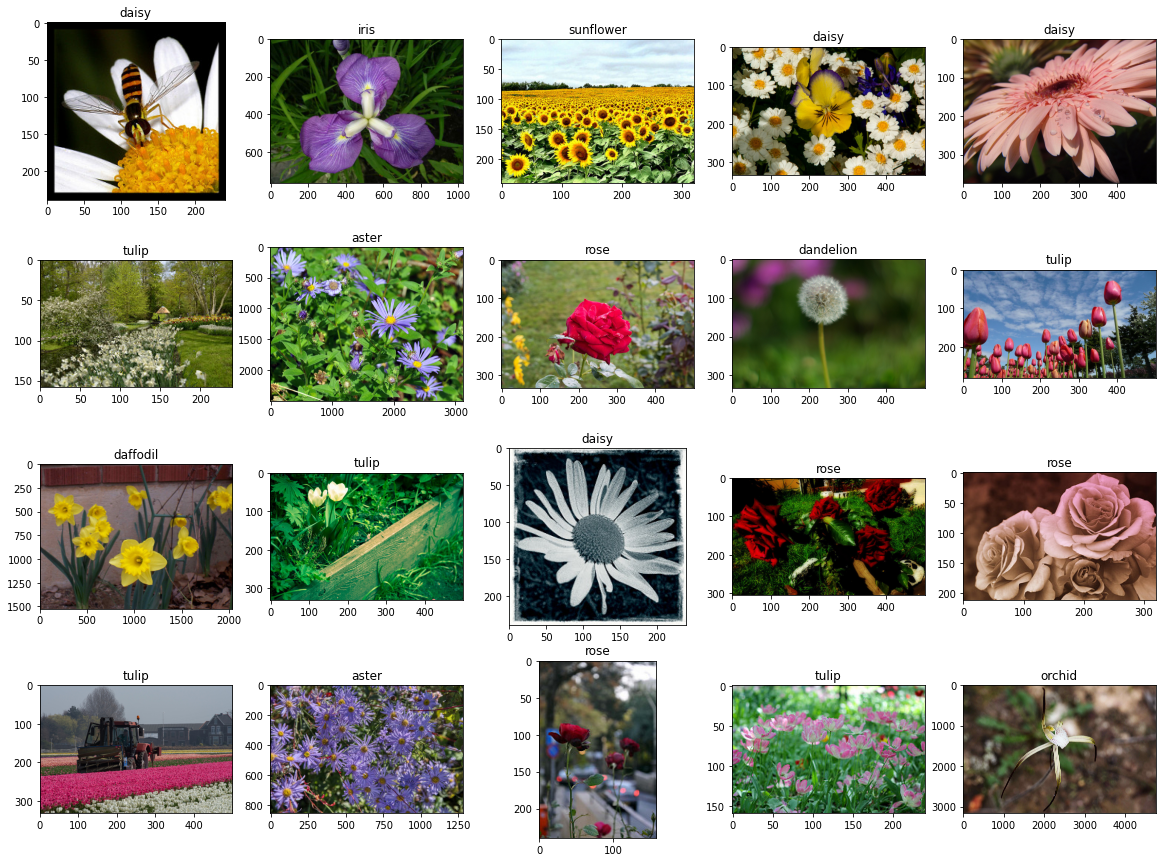

In [4]:
show_random_images(path, flowers)

The images are different sizes, so we will need to resize all of them before feeding them to a neural network. Let's try this first with PIL.

## Image Resizing
Since all images are of different proportions we will need to open the images with PIL and then resize them.

In [5]:
## Compute total number of images
total_images = 0
for flower in flowers:
    total_images += len([name for name in os.listdir(path + flower + '/')])


## Create an array of resized images
images = np.empty((total_images, 64, 64, 3),dtype=np.int32)
labels = np.empty(total_images,dtype=np.int32)
n = 0
for i in range(len(flowers)):
    im_path = path + flowers[i] + '/'
    for name in os.listdir(im_path):
        labels[n] = i
        images[n,:,:,:] = np.array(PIL.Image.open(im_path + name).resize((64,64), PIL.Image.BICUBIC))
        n += 1

The images are now stored in a $(m \times 64 \times 64 \times 3)$ array, where $m$ is the number of training examples. Let's see how the resized images look.

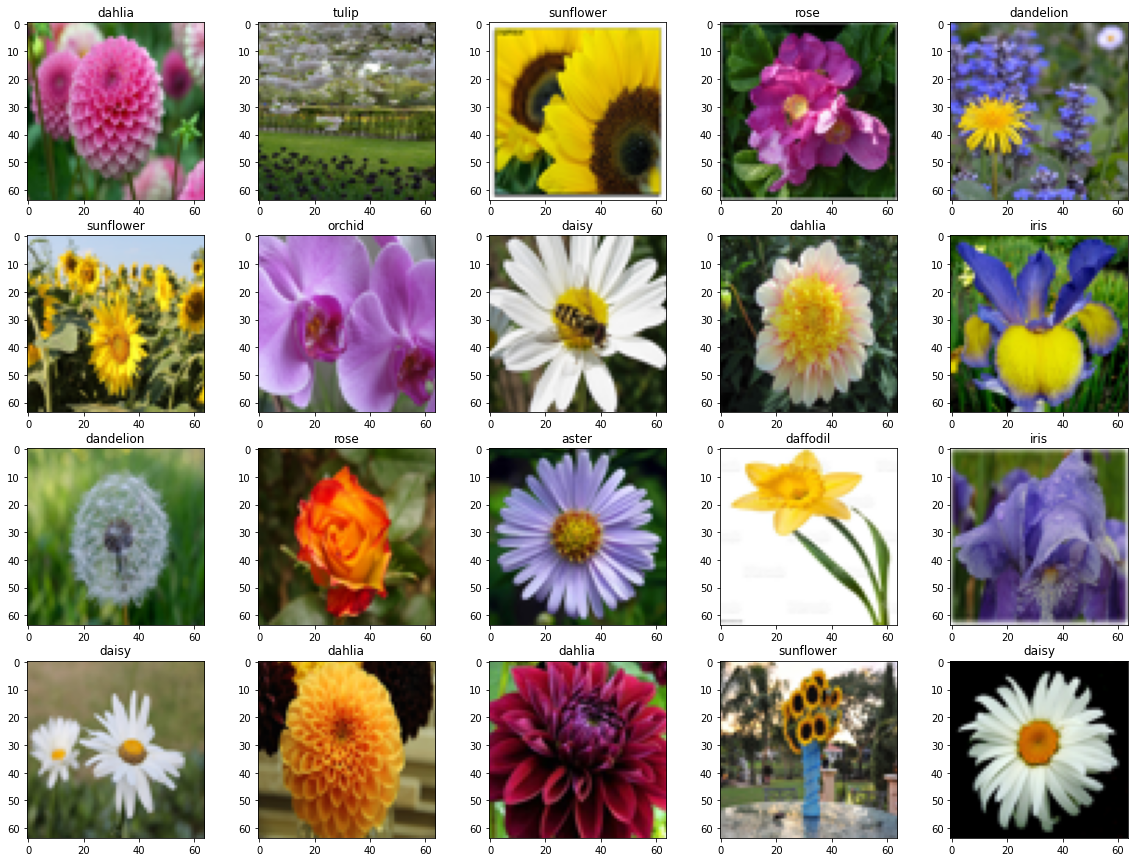

In [6]:
## Plot 20 random images that have been resized in the aprevious step
randomlist = random.sample(range(0, images.shape[0]), 20)
i = 1
for r in randomlist:
    plt.subplot(4,5,i).set_title('{}'.format(flowers[labels[r]]))
    plt.imshow(images[r,:,:,:])
    i += 1

These look pretty decent! It's time to prepare the data by flattening the image arrays and splitting the data into testing and training data.

### Data preparation and Train/Test Split

First thing we will want to do is one-hot encode the target values (i.e., labels).

In [7]:
## Define function that will one-hot encode the target values
def one_hot_encode(target):
    n_values = np.max(target) + 1
    one_hot = np.eye(n_values)[target]
    return(one_hot)

y = one_hot_encode(labels) # one-hot encode target values
X = images / np.max(images) # normalize input images

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (8168, 64, 64, 3)
y shape: (8168, 10)


Looks like we have 8,100 images to work with. It is time to perform a train/test split on the data. For now, I will try an 90/10 train/test split.

In [8]:
## Split X and y into training and test features + target.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Quick sanity check to make sure we have the desired array shapes
print("X training shape:", X_train.shape)
print("y training shape:", y_train.shape)
print("X testing shape:", X_test.shape)
print("y testing shape:", y_test.shape)

X training shape: (7351, 64, 64, 3)
y training shape: (7351, 10)
X testing shape: (817, 64, 64, 3)
y testing shape: (817, 10)


## Build the model

Time to build the model! In the following block of code I add all the layers to the keras.Sequential(\[\]) model. First I will perform data augmentation. Then, the first hidden layer will perform a 2D convolution on the input data followed by a 2D max pooling. This process is repeated once more and then we add two dense layers with 512 units follwed by the output layer. I use dropout regularization to reduce overfitting.

In [9]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1],X.shape[2],X.shape[3])),
    RandomFlip('horizontal'), # data augmentation
    RandomRotation(0.2),
    tfl.Conv2D(8, 4, strides=1, padding='same'),
    tfl.Activation('tanh'),
    tfl.MaxPool2D(pool_size=8, strides=8, padding='same'),
    tfl.Conv2D(16, 2, strides=1, padding='same'),
    tfl.Activation('tanh'),
    tfl.MaxPool2D(pool_size=4,strides=4,padding='same'),
    tfl.Flatten(),
    tfl.Dense(512),
    tfl.Dropout(0.2),
    tfl.Activation('tanh'),
    tfl.Dense(512),
    tfl.Dropout(0.2),
    tfl.Activation('tanh'),
    tfl.Dense(256),
    tfl.Dropout(0.2),
    tfl.Activation('relu'),
    tfl.Dense(units=len(flowers), activation='softmax')
])

2022-02-02 17:13:16.899029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 17:13:17.003202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 17:13:17.003882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 17:13:17.005120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
## Define the optimizer, loss function, metric score and compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# View summary of model and trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 64, 64, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 16)          0

Let's fit the model!

In [11]:
## Define train and test data sets with batch size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

## Fit the model with 100 epochs
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

2022-02-02 17:13:20.171269: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 722632704 exceeds 10% of free system memory.
2022-02-02 17:13:20.881837: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 722632704 exceeds 10% of free system memory.
2022-02-02 17:13:21.553318: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 722632704 exceeds 10% of free system memory.
2022-02-02 17:13:21.997042: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 722632704 exceeds 10% of free system memory.


Epoch 1/100


2022-02-02 17:13:23.103480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-02 17:13:24.128120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


115/115 [==============================] - 8s 10ms/step - loss: 1.8621 - accuracy: 0.3200 - val_loss: 1.5819 - val_accuracy: 0.4235


2022-02-02 17:13:30.872289: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 722632704 exceeds 10% of free system memory.


Epoch 2/100
115/115 [==============================] - 1s 9ms/step - loss: 1.5201 - accuracy: 0.4569 - val_loss: 1.3955 - val_accuracy: 0.5104
Epoch 3/100
115/115 [==============================] - 1s 9ms/step - loss: 1.4027 - accuracy: 0.4889 - val_loss: 1.3432 - val_accuracy: 0.5092
Epoch 4/100
115/115 [==============================] - 1s 8ms/step - loss: 1.3361 - accuracy: 0.5228 - val_loss: 1.3264 - val_accuracy: 0.5116
Epoch 5/100
115/115 [==============================] - 1s 8ms/step - loss: 1.2831 - accuracy: 0.5364 - val_loss: 1.2756 - val_accuracy: 0.5177
Epoch 6/100
115/115 [==============================] - 1s 10ms/step - loss: 1.2549 - accuracy: 0.5588 - val_loss: 1.2814 - val_accuracy: 0.5410
Epoch 7/100
115/115 [==============================] - 1s 8ms/step - loss: 1.2326 - accuracy: 0.5650 - val_loss: 1.2644 - val_accuracy: 0.5422
Epoch 8/100
115/115 [==============================] - 1s 8ms/step - loss: 1.2110 - accuracy: 0.5737 - val_loss: 1.1838 - val_accuracy: 0.570

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

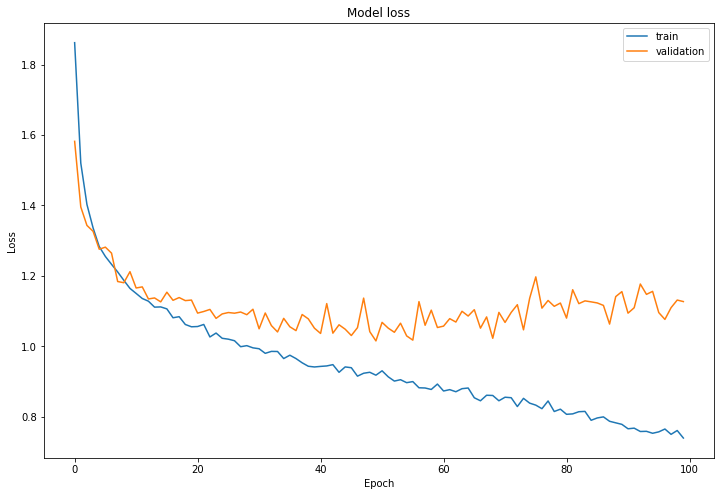

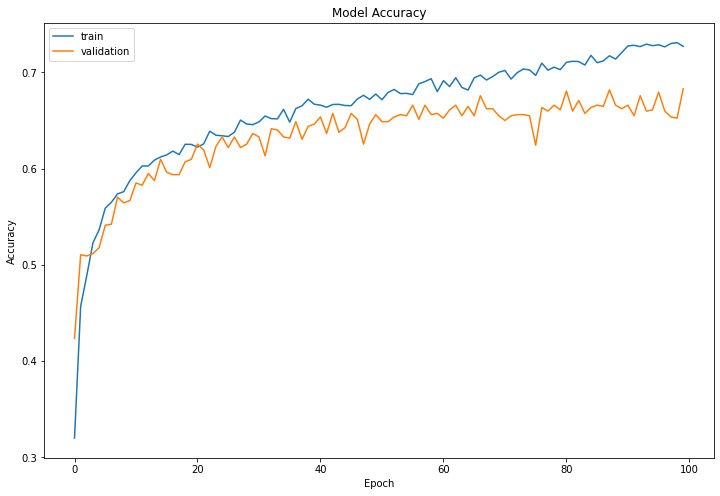

In [12]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

Not too bad. After running this several times the training accuracy always ends up at around 74% while the test accuracy typically ends up at around ~72%. 